In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os

In [3]:
def load_sensor_data(filename):
    df = pd.read_csv(f'../Data/raw_data/{filename}', sep=',')

    # Split the data into columns
    df[['Cycle','Position','Reading']] = df['Data'].str.split(':', expand=True)
    df.drop(columns=['Data','Index'], inplace=True)

    # Clean 
    df.dropna(inplace=True)

    # Convert the data types
    df['Cycle'] = df['Cycle'].astype(int)
    df['Position'] = df['Position'].astype(int)
    df['Reading'] = df['Reading'].astype(float)

    df['Position_Gradient'] = np.gradient(df['Position'])
    df['Direction'] = df['Position_Gradient'] > 0

    # print(df.tail())
    print(f"Data loaded from {filename}")

    return df

In [4]:
df = None
df_split = None
df_plot = None

file_name = 'data_filmed_0204_220747.csv'

# List files in the directory
files = os.listdir('../Data/raw_data')
# List files in the directory sorted by creation date
files = sorted(os.listdir('../Data/raw_data'), key=lambda x: os.path.getctime(os.path.join('../Data/raw_data', x)))

# Create a dropdown widget
file_dropdown = widgets.Dropdown(
    options=files,
    description='Select File:',
    disabled=False,
)

# Display the dropdown widget
display(file_dropdown)

df = load_sensor_data(files[-1])

# Update the file_name based on the selection
def on_file_change(change):
    global file_name, df
    file_name = change['new']

    df = load_sensor_data(file_name)

file_dropdown.observe(on_file_change, names='value')

Dropdown(description='Select File:', options=('formatted_data_0123_224049.csv', 'formatted_data_0123_224103.cs…

Data loaded from data_sa3_0212_205226.csv


Data loaded from data_big2_0211_204330.csv


Text(0, 0.5, 'Resistance (ADC Value)')

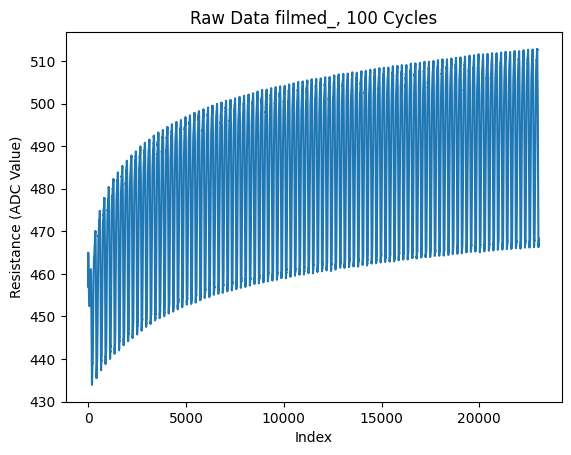

In [5]:
# df.plot(x='Cycle', y='Reading',c='Position',colormap='jet', kind='scatter')
# plt.scatter(df.index, df['Reading'], c=df['Position'], cmap='viridis',s=3)
plt.plot(df.index, df['Reading'])
plt.title(f'Raw Data {file_name[5:12]}, 100 Cycles')
plt.xlabel('Index')
plt.ylabel('Resistance (ADC Value)')

,Cycle,Position,Reading,Position_Gradient,Direction
1,0,-1,508.00,-5.0,False
2,0,-6,497.01,-5.0,False
3,0,-11,497.13,-5.0,False
4,0,-16,497.35,-5.0,False
5,0,-21,497.27,-5.0,False


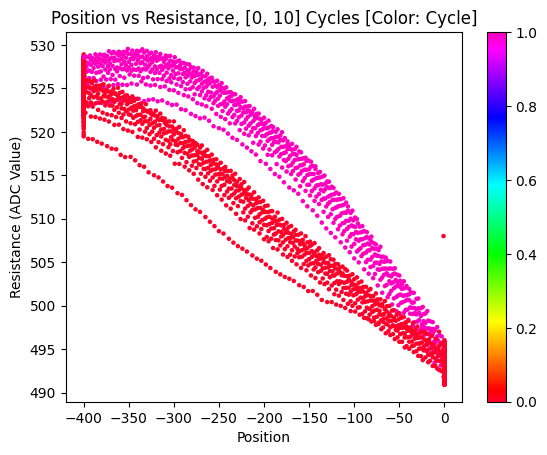

In [14]:
bounds = [0,10]
df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
plt.scatter(df_plot['Position'], df_plot['Reading'], c=df_plot['Direction'], cmap='gist_rainbow',s=5)
plt.title(f'Position vs Resistance, {bounds} Cycles [Color: Cycle]')
plt.xlabel('Position')
plt.ylabel('Resistance (ADC Value)')
plt.colorbar()
df_plot.head()

In [15]:
def plot_pr_curve(df, bounds):
    df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
    plt.scatter(df_plot['Position'], df_plot['Reading'], c=df_plot['Cycle'], cmap='gist_rainbow',s=5)
    plt.title(f'Position vs Resistance, {bounds} Cycles [Color: Cycle]')
    plt.xlabel('Position')
    plt.ylabel('Resistance (ADC Value)')
    plt.colorbar()

def plot_data(df, bounds):
    df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
    df_plot2 = df_plot[(df_plot['Position'] == -400) | (df_plot['Position'] == 0)]
    plt.plot(df_plot.index, df_plot['Reading'])
    plt.scatter(df_plot2.index, df_plot2['Reading'], c=df_plot2['Position'], cmap='viridis',s=5)
    plt.title('Raw Data, 100 Cycles')
    plt.xlabel('Index')
    plt.ylabel('Resistance (ADC Value)')
    plt.show()


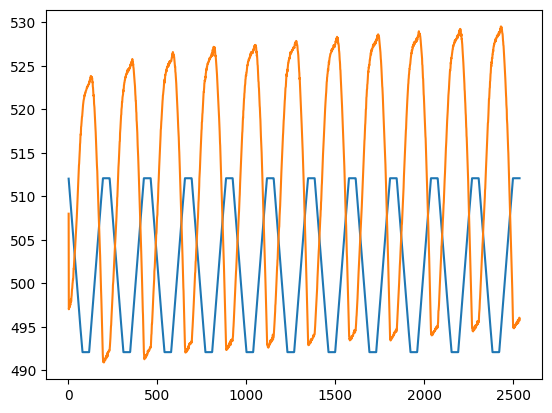

In [17]:
plt.plot(df_plot.index, (df_plot['Position']*.05)+df_plot['Reading'].mean())
plt.plot(df_plot.index, df_plot['Reading'])

Data loaded from data_sml1_0210_215326.csv
Data loaded from data_med1_0210_213949.csv
Data loaded from data_big1_0210_212224.csv


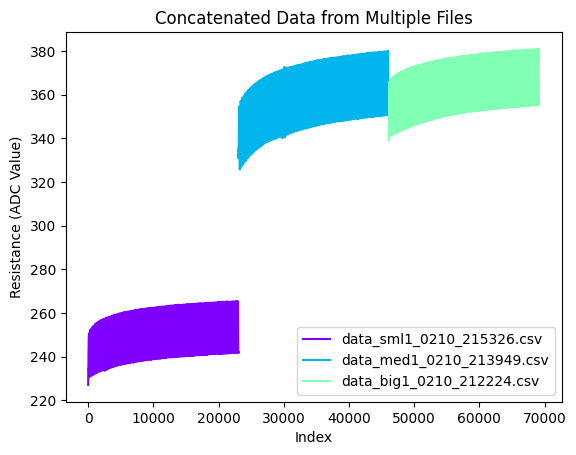

In [10]:

df_concat = pd.DataFrame()

colors = plt.cm.rainbow(np.linspace(0, 1, len(files[-6:-1])))

files_list = ["data_sml1_0210_215326.csv", "data_med1_0210_213949.csv", "data_big1_0210_212224.csv"]

# for i, file in enumerate(files[-6:-1]):
for i, file in enumerate(files_list):
    df = load_sensor_data(file)
    df['Index_Offset'] = df.index + len(df_concat)
    df_concat = pd.concat([df_concat, df])
    plt.plot(df['Index_Offset'], df['Reading'], color=colors[i], label=file)


plt.title('Concatenated Data from Multiple Files')
plt.xlabel('Index')
plt.ylabel('Resistance (ADC Value)')
plt.legend()
plt.show()

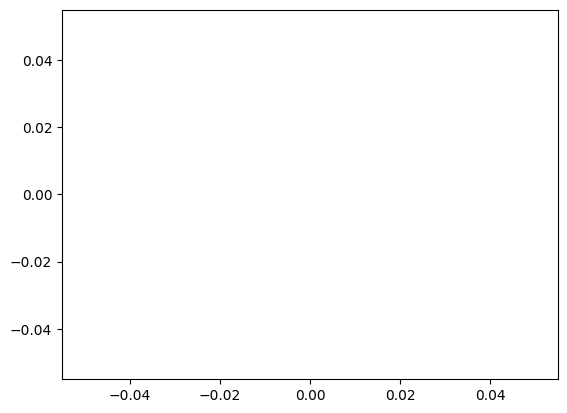

In [19]:
df_model = df[(df['Cycle'] >= 10) & (df['Direction'] == 1) & (df['Position'] != 0) & (df['Position'] != -400)]
# plt.scatter(df_model['Position'], df_model['Reading'])

plt.plot(df_model[df_model['Position'] == 400]['Position'],df_model[df_model['Position'] == 400]['Reading'])

True
Solutions for y=460: []


ValueError: x and y must be the same size

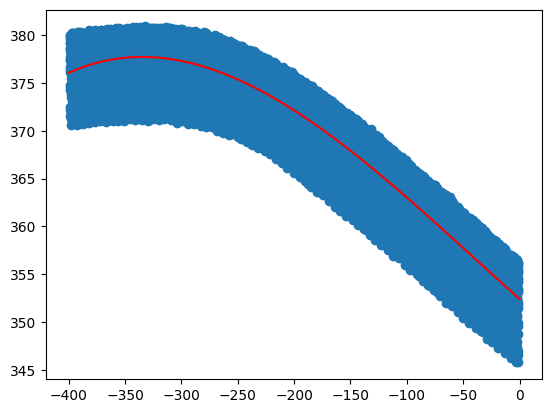

In [12]:
import numpy

import matplotlib.pyplot as plt

# x = [1,2,3,5,6,7,8,9,10,12,13,14,15,16,18,19,21,22]
# y = [100,90,80,60,60,55,60,65,70,70,75,76,78,79,90,99,99,100]
x = df_model['Position']
y = df_model['Reading']

mymodel = numpy.poly1d(numpy.polyfit(x, y, 3))

# myline = numpy.linspace(1, 22, 100)
pos = np.linspace(-400, 0, 100)
# print(pos)

plt.scatter(x, y)
plt.plot(pos, mymodel(pos), color='red')
# plt.scatter(x[x == -200], y[x == -200], color='green')


# Solve the model at a given y value
y_value = 460
x_value = (mymodel - y_value).roots
print(x_value[0].imag == 0)
real_roots = [float(root.real) for root in x_value if root.imag == 0 and root.real >= -400 and root.real <= 0]
print(f"Solutions for y={y_value}: {real_roots}")

def get_solution(y_value):
    x_value = (mymodel - y_value).roots
    # lame and bloated one liner
    real_roots = [float(root.real) for root in x_value if root.imag == 0 and root.real >= -400 and root.real <= 0]
    if len(real_roots) == 0:
        return None
    return real_roots[0]

plt.scatter(real_roots, [y_value], color='green')
plt.show()

plt.plot(df_model[df['Direction'] == 1].index, df_model[df_model['Direction'] == 1]['Position'])
# df_model['Prediction'] = get_solution(df_model['Position'])
df_model['Prediction'] = df_model['Reading'].apply(get_solution)
plt.plot(df_model[df['Direction'] == 1].index, df_model[df['Direction'] == 1]['Prediction'], color='orange')
# plt.plot(df_model.index, df_model['Prediction'])

df_model.tail()


Data loaded from data_big1_0210_212224.csv
Data loaded from data_big2_0211_204330.csv
Data loaded from data_big3_0211_211148.csv


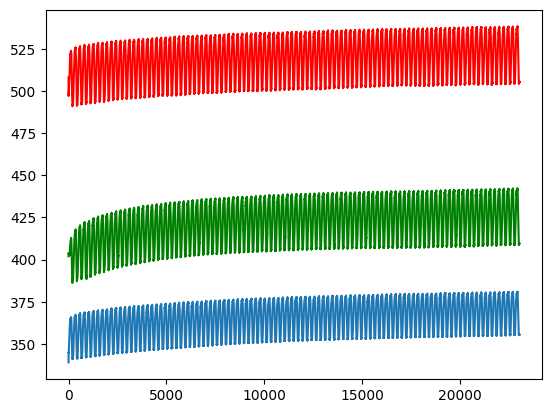

In [ ]:
df_big1 = load_sensor_data('data_big1_0210_212224.csv')
df_big2 = load_sensor_data('data_big2_0211_204330.csv')
df_big3 = load_sensor_data('data_big3_0211_211148.csv')

plt.plot(df_big1.index, df_big1['Reading'])
plt.plot(df_big2.index, df_big2['Reading'], color='red')
plt.plot(df_big3.index, df_big3['Reading'], color='green')

Data loaded from data_med1_0210_213949.csv
Data loaded from data_med2_0212_143649.csv


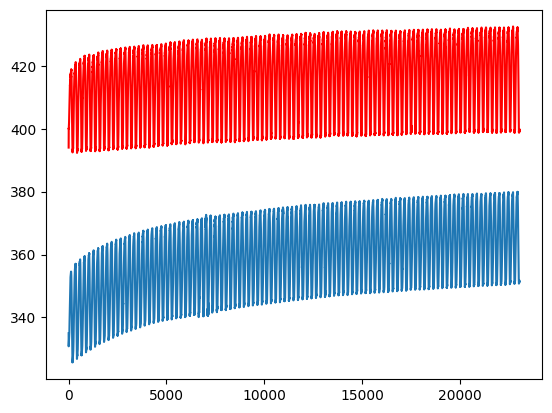

In [ ]:
df_med1 = load_sensor_data('data_med1_0210_213949.csv')
df_med2 = load_sensor_data('data_med2_0212_143649.csv')


plt.plot(df_med1.index, df_med1['Reading'])
plt.plot(df_med2.index, df_med2['Reading'], color='red')

Data loaded from data_sa1_0212_153547.csv
Data loaded from data_sa2_0212_200504.csv
Data loaded from data_sa3_0212_205226.csv


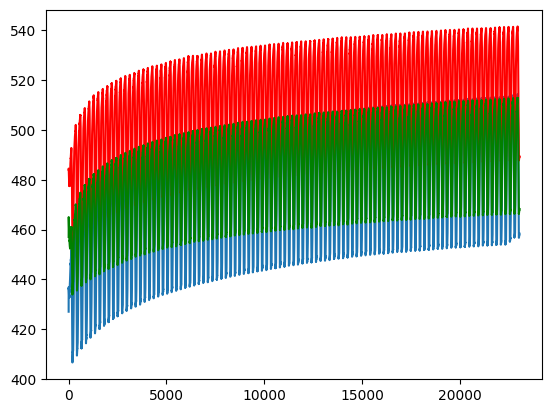

In [ ]:
df_sa1 = load_sensor_data('data_sa1_0212_153547.csv')
df_sa2 = load_sensor_data('data_sa2_0212_200504.csv')
df_sa3 = load_sensor_data('data_sa3_0212_205226.csv')

plt.plot(df_sa1.index, df_sa1['Reading'])
plt.plot(df_sa2.index, df_sa2['Reading'], color='red')
plt.plot(df_sa3.index, df_sa3['Reading'], color='green')


Data loaded from data_ma2_0212_152231.csv
Data loaded from data_ma2_0212_194710.csv
Data loaded from data_ma3_0212_204030.csv


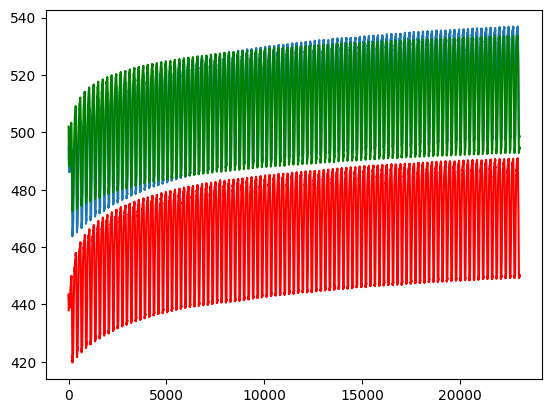

In [ ]:
df_ma1 = load_sensor_data('data_ma2_0212_152231.csv')
df_ma2 = load_sensor_data('data_ma2_0212_194710.csv')
df_ma3 = load_sensor_data('data_ma3_0212_204030.csv')

plt.plot(df_ma1.index, df_ma1['Reading'])
plt.plot(df_ma2.index, df_ma2['Reading'], color='red')
plt.plot(df_ma3.index, df_ma3['Reading'], color='green')


In [ ]:
# List files in the directory
test_files = os.listdir('./test_run_trace_amp')
test_files = sorted(test_files)

# Initialize a DataFrame to concatenate all data
df_test_concat = pd.DataFrame()

# Define colors for plotting
test_colors = plt.cm.rainbow(np.linspace(0, 1, len(test_files)))

# Plot each file
for i, file in enumerate(test_files):
    df_test = load_sensor_data(file)
    df_test['Index_Offset'] = df_test.index + len(df_test_concat)
    df_test_concat = pd.concat([df_test_concat, df_test])
    plt.plot(df_test['Index_Offset'], df_test['Reading'], color=test_colors[i], label=file)

plt.title('Concatenated Data from Test Run Trace Width Files')
plt.xlabel('Index')
plt.ylabel('Resistance (ADC Value)')
plt.legend()
plt.show()

NameError: name 'os' is not defined